In [1]:
import sys
sys.path.append("..")

In [2]:
import numpy as np
np.seterr(divide="ignore")
import logging
import pickle
import glob

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import RobustScaler
from sklearn.utils import check_random_state

from scipy import interp

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6, 6)

In [3]:
def evaluate_models(pattern):
    rocs = []
    fprs = []
    tprs = []
    
    for filename in glob.glob(pattern):            
        data = pickle.load(open(filename, "rb"))
        y = data[:, 0]
        y_pred = data[:, 1]
        
        # Roc
        rocs.append(roc_auc_score(y, y_pred))
        fpr, tpr, _ = roc_curve(y, y_pred)
        
        fprs.append(fpr)
        tprs.append(tpr)
        
    return rocs, fprs, tprs

def plot_rocs(rocs, fprs, tprs, label="", color="r", show_all=False):
    inv_fprs = []
    base_tpr = np.linspace(0.05, 1, 476)
    
    for fpr, tpr in zip(fprs, tprs):
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
        if show_all:
            plt.plot(base_tpr, inv_fpr, alpha=0.1, color=color)
        
    inv_fprs = np.array(inv_fprs)
    mean_inv_fprs = inv_fprs.mean(axis=0)


    plt.plot(base_tpr, mean_inv_fprs, color, 
             label="%s" % label)
    
def plot_show(filename=None):
    plt.xlabel("Signal efficiency")
    plt.ylabel("1 / Background efficiency")
    plt.xlim([0.1, 1.0])
    plt.yscale("log")
    plt.legend(loc="best")
    plt.grid()
    
    if filename:
        plt.savefig(filename)
    
    plt.show()
    
def report_score(rocs, fprs, tprs, label, latex=False):       
    inv_fprs = []
    base_tpr = np.linspace(0.05, 1, 476)
    
    for fpr, tpr in zip(fprs, tprs):
        inv_fpr = interp(base_tpr, tpr, 1. / fpr)
        inv_fprs.append(inv_fpr)
        
    inv_fprs = np.array(inv_fprs)
    mean_inv_fprs = inv_fprs.mean(axis=0)
    
    if not latex:
        print("%32s\tROC AUC=%.4f+-%.2f\t1/FPR@TPR=0.5=%.2f+-%.2f" %  (label, 
                                                                       np.mean(rocs), 
                                                                       np.std(rocs),
                                                                       np.mean(inv_fprs[:, 375]), # was 225 for 50%
                                                                       np.std(inv_fprs[:, 375])))
    else:
        print("%30s \t& %.4f $\pm$ %.4f \t& %.1f $\pm$ %.1f \\\\" % 
              (label,
               np.mean(rocs), 
               np.std(rocs),
               np.mean(inv_fprs[:, 375]),
               np.std(inv_fprs[:, 375])))

                             1 	& 0.9602 $\pm$ 0.0004 	& 26.7 $\pm$ 0.7 \\
                             2 	& 0.9866 $\pm$ 0.0007 	& 156.9 $\pm$ 14.8 \\
                             5 	& 0.9867 $\pm$ 0.0004 	& 152.8 $\pm$ 10.4 \\


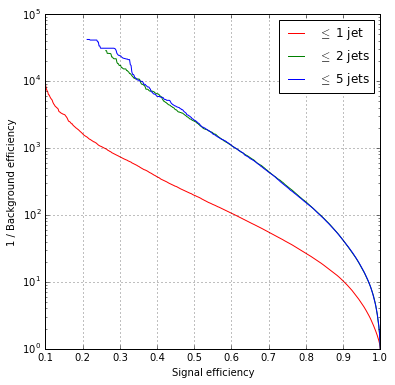

In [7]:
for n_jets, color in [(1, "r"), (2, "g"), (5, "b")]:
    pattern = "antikt-kt"

    r, f, t = evaluate_models("../models/event-study/predictions-reversed/predictions-e-full-%s-%d-*.pickle" % (pattern, n_jets))
    plot_rocs(r, f, t, label=r"$\leq$ %d jet%s" % (n_jets, "" if n_jets==1 else "s"), color=color, show_all=False)
    report_score(r, f, t, label=str(n_jets), latex=True)

plot_show(filename="event-n-jets.pdf")

In [44]:
for n_jets in [1, 2, 5]:
    for pattern, color in [
            ("antikt-kt", "r"),
            ("antikt-seqpt-reversed", "r"),
            #("antikt-seqpt-reversed-towers", "towers", "g"),
            #("antikt-seqpt-reversed-towers-pflow", "towers+pflow", "b"),
        ]:

        r, f, t = evaluate_models("../models/event-study/predictions-reversed/predictions-e-full-%s-%d-*.pickle" % (pattern, n_jets))
        report_score(r, f, t, label=str(n_jets), latex=True)
        
for pattern, n_jets, label, color in [
        ("jet4v", 1, "1 jet4v", "r"),
        ("jet4v", 2, "2 jet4v", "b"),
        ("jet4v", 5, "5 jet4v", "g")
    ]:
    
    r, f, t = evaluate_models("../models/event-study/predictions-reversed/predictions-e-4v-%s-%d-*.pickle" % (pattern, n_jets))
    report_score(r, f, t, label=label, latex=True)
    
for pattern, n_jets, label, color in [
        ("all4v", 1, "1 all4v", "r"),
        ("all4v", 50, "50 all4v", "g"),
        ("all4v", 100, "100 all4v", "b"),
        ("all4v", 200, "200 all4v", "c"),
        ("all4v", 400, "400 all4v", "m")
    ]:
    
    r, f, t = evaluate_models("../models/event-study/predictions-reversed/predictions-e-4v-%s-%d-*.pickle" % (pattern, n_jets))
    report_score(r, f, t, label=label, latex=True)

                             1 	& 0.9602 $\pm$ 0.0004 	& 26.7 $\pm$ 0.7 \\
                             1 	& 0.9594 $\pm$ 0.0010 	& 25.6 $\pm$ 1.4 \\
                             2 	& 0.9866 $\pm$ 0.0007 	& 156.9 $\pm$ 14.8 \\
                             2 	& 0.9875 $\pm$ 0.0006 	& 174.5 $\pm$ 14.0 \\
                             5 	& 0.9867 $\pm$ 0.0004 	& 152.8 $\pm$ 10.4 \\
                             5 	& 0.9872 $\pm$ 0.0003 	& 167.8 $\pm$ 9.5 \\
                       1 jet4v 	& 0.8909 $\pm$ 0.0007 	& 5.6 $\pm$ 0.0 \\
                       2 jet4v 	& 0.9606 $\pm$ 0.0011 	& 21.1 $\pm$ 1.1 \\
                       5 jet4v 	& 0.9576 $\pm$ 0.0019 	& 20.3 $\pm$ 0.9 \\
                       1 all4v 	& 0.6501 $\pm$ 0.0023 	& 1.7 $\pm$ 0.0 \\
                      50 all4v 	& 0.8925 $\pm$ 0.0079 	& 5.6 $\pm$ 0.5 \\
                     100 all4v 	& 0.8781 $\pm$ 0.0180 	& 4.9 $\pm$ 0.6 \\
                     200 all4v 	& 0.8846 $\pm$ 0.0091 	& 5.2 $\pm$ 0.5 \\
                     40

# Count parameters

In [45]:
def count(params):
    def _count(thing):
        if isinstance(thing, list):
            c = 0
            for stuff in thing:
                c += _count(stuff)
            return c 

        elif isinstance(thing, np.ndarray):
            return np.prod(thing.shape)
    
    c = 0
    for k, v in params.items():
        c += _count(v)
    return c
    
# Simple vs gated
fd = open("../models/event-study/model-e-full-antikt-kt-1-1.pickle", "rb")
params = pickle.load(fd)
fd.close()
print("Simple =", count(params))   

('Simple =', 18681)


In [46]:
params

{'W_clf': [array([[-0.01879265,  0.12167948,  0.05035893, ..., -0.01513335,
           0.01769368,  0.0184784 ],
         [-0.09257675,  0.20137325,  0.07307229, ...,  0.00381305,
           0.02993886,  0.00911687],
         [-0.0496274 ,  0.12184974,  0.06705015, ...,  0.03035775,
           0.07714101,  0.03544785],
         ..., 
         [-0.07723944,  0.13333639,  0.03686497, ...,  0.00210926,
           0.05933862,  0.00400085],
         [-0.02276393, -0.01041212, -0.00182888, ..., -0.00364235,
          -0.00650449, -0.02148335],
         [-0.01336965,  0.14102805,  0.06182186, ..., -0.01678019,
           0.06684246,  0.03531396]]),
  array([[-0.01825787, -0.10482513, -0.076065  , ..., -0.04278567,
           0.01373406, -0.02729302],
         [-0.00989853, -0.03377796, -0.01971048, ..., -0.02333645,
          -0.02379274,  0.00634366],
         [-0.01391392, -0.00220749,  0.01460803, ..., -0.00829536,
          -0.02685779, -0.01533192],
         ..., 
         [ 0.05855084, 